# Data preparation

In [62]:
from lib import *

In [63]:
# reindex
df_wrime_target = df_wrime_target.reset_index(drop=True)
# df_wrime_target.info()

In [64]:
sentences = df_wrime_target['Sentence'].tolist()

# replace '\n' with ''
sentences = [sentence.replace('\\n', ' ') for sentence in sentences]
# replace 'x000D' with ''
sentences = [sentence.replace('x000D', ' ') for sentence in sentences]

# Prepare embeddings of tweets based on emotional intensities. 

In [65]:
flag = "fine_tuned" # or  or "word2vec" #  "pretrained" # 

In [66]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# Load pretrained model/tokenizer. 
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking' # 'cl-tohoku/bert-base-japanese-v2'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

embedding_path = "output"
if not os.path.isdir(embedding_path):
    os.makedirs(embedding_path)

if flag == "pretrained":
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, output_hidden_states=True) # output_hidden_states=True allows us to access hidden states. 
    path_to_embeddings = os.path.join(embedding_path, 'pretrained_embeddings.tsv')
    permutation_for_cluster_IDs = [5, 2, 4, 6, 3, 1]

elif flag == "fine_tuned":
    # model = AutoModelForSequenceClassification.from_pretrained("trained_model", output_hidden_states=True) # output_hidden_states=True allows us to access hidden states.
    model = AutoModelForSequenceClassification.from_pretrained(os.path.join("output", "trained_model"), output_hidden_states=True) # output_hidden_states=True allows us to access hidden states.
    path_to_embeddings = os.path.join(embedding_path, 'fine-tuned_embeddings.tsv')
    permutation_for_cluster_IDs = [5, 2, 1, 4, 3, 6]

elif flag == "word2vec":
    path_to_embeddings = os.path.join(embedding_path, 'word2vec_embeddings.tsv')
    permutation_for_cluster_IDs = [1, 2, 3, 4, 5, 6] # To-do: change this to ?

if os.path.isfile(path_to_embeddings):
    df_embeddings = pd.read_table(path_to_embeddings, header=None)
else:
    if flag == "word2vec":
        df_embeddings = make_embeddings_by_word2vec(sentences)
    else:
        df_embeddings = make_embeddings_by_bert(sentences, tokenizer, model, path_to_embeddings)

---

# K-means clustering by embeddings. 

In [67]:
from sklearn.cluster import KMeans

k = 6 # number of clusters
kmeansModel = KMeans(n_clusters=k, random_state=0).fit(df_embeddings)

# Cluster ID (0-based) for each tweet. 
clusters = kmeansModel.labels_
# Cluster ID is 1-based. 
clusters = clusters + 1
print(kmeansModel.labels_)
print(len(kmeansModel.labels_))
print(clusters)

/home/om/.miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[0 5 3 ... 2 1 2]
18237
[1 6 4 ... 3 2 3]


In [68]:
# Load the intensity-based clusters
_df = pd.read_csv(os.path.join('output', 'emotion_6_clusters.tsv'), sep='\t', header=None)
# emotion_clusters = _df[0].tolist()
# emotion_clusters = [int(x) for x in emotion_clusters]
emotion_clusters = [int(x) for x in _df[0].tolist()]
df_intensity_clusters = pd.DataFrame(emotion_clusters, columns=['labels'])
df_intensity_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18237 entries, 0 to 18236
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  18237 non-null  int64
dtypes: int64(1)
memory usage: 142.6 KB


## Comparison of the pretrain model embedding-based clusters with the intensity-based clusters. 

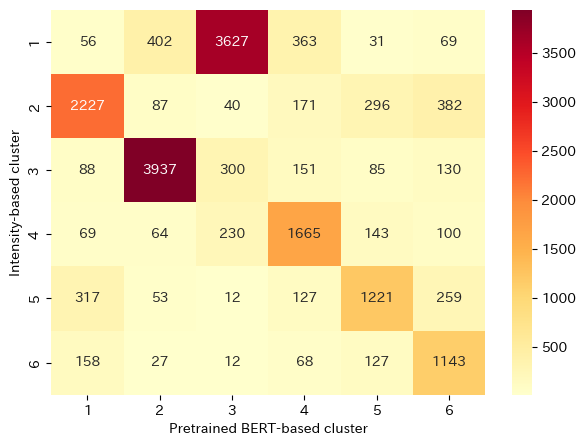

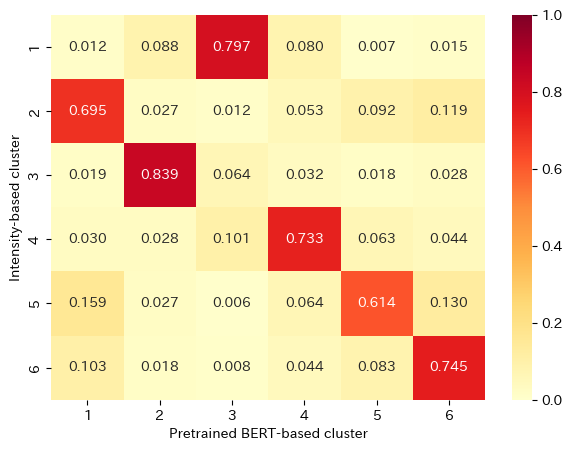

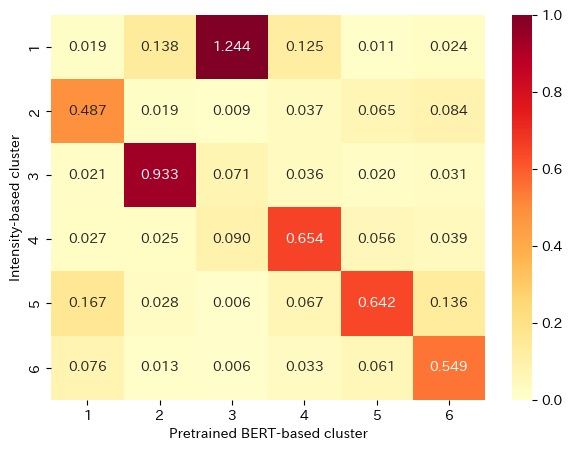

In [69]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])
conf_mat = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters))) # confusion matrix
conf_mat_norm_by_row = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalize the confusion matrix by row. 
conf_mat_norm_by_column = conf_mat.astype('float') / conf_mat.sum(axis=0)[:, np.newaxis] # Normalize the confusion matrix by row. 

# Heatmap of the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_row, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_column, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()


In [70]:
# Rename cluster IDs for pretrain or fine-tuning
# pretrained
# clusters[clusters == 1] = -5
# clusters[clusters == 2] = -2
# clusters[clusters == 3] = -4
# clusters[clusters == 4] = -6
# clusters[clusters == 5] = -3
# clusters[clusters == 6] = -1

# 多分 fine-tuned 用．
# clusters[clusters == 1] = -5 
# clusters[clusters == 2] = -2
# clusters[clusters == 3] = -1
# clusters[clusters == 4] = -4
# clusters[clusters == 5] = -3
# clusters[clusters == 6] = -6

indexes = range(1,len(permutation_for_cluster_IDs)+1)
for index, val in zip(indexes, permutation_for_cluster_IDs):
    clusters[clusters == index] = -val

for id in range(1,7):
    clusters[clusters == -id] = id
print(clusters)

[5 6 4 ... 1 2 1]


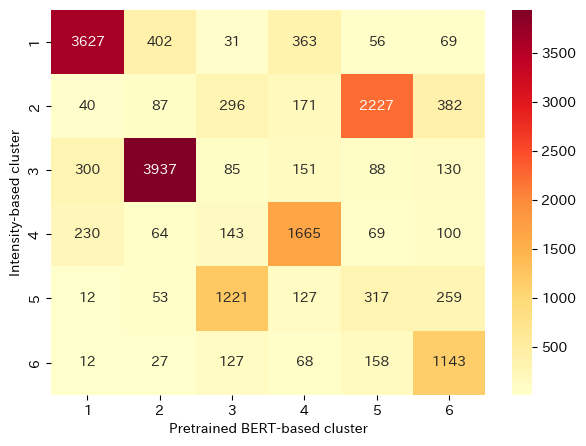

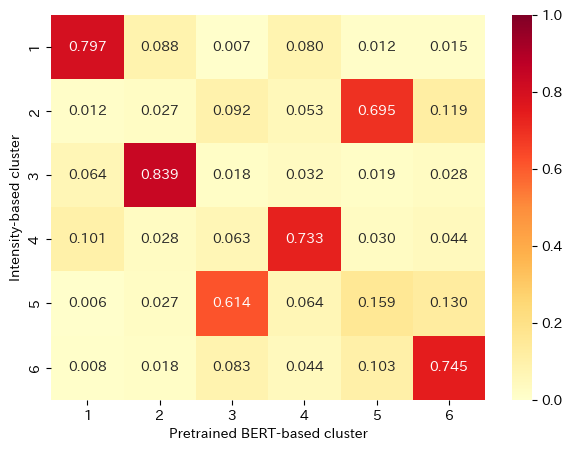

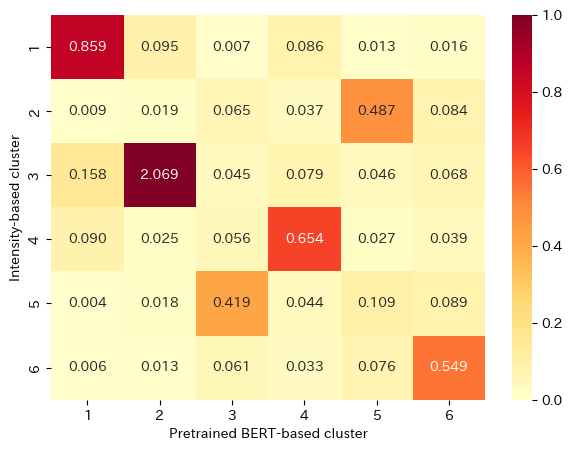

In [71]:
df_clusters = pd.DataFrame(clusters, columns=['clusters'])
conf_mat = confusion_matrix(df_intensity_clusters['labels'], df_clusters['clusters'], labels=list(set(emotion_clusters))) # confusion matrix
conf_mat_norm_by_row = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] # Normalize the confusion matrix by row. 
conf_mat_norm_by_column = conf_mat.astype('float') / conf_mat.sum(axis=0)[:, np.newaxis] # Normalize the confusion matrix by row. 

# Heatmap of the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_row, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Heatmap of the normalized confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat_norm_by_column, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Pretrained BERT-based cluster')
plt.ylabel('Intensity-based cluster')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

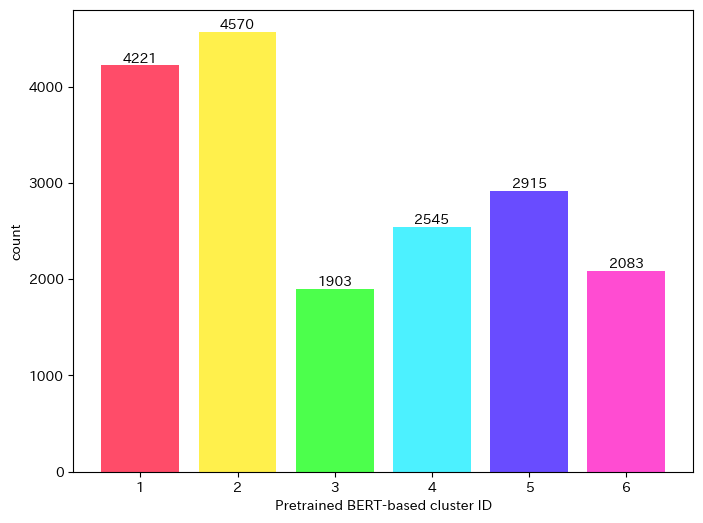

In [72]:
# setting Japanese font
font_manager.fontManager.addfont('fonts/ipaexg.ttf')
matplotlib.rc('font', family="IPAexGothic")

# frequency of each cluster
cluster_IDs, counts = np.unique(clusters, return_counts=True) # cluster_IDs = [1, 2, 3, 4, 5, 6]

colors = cmap(np.linspace(0, 1, len(cluster_IDs)))

plt.figure(figsize=(8, 6))
bars = plt.bar(cluster_IDs, counts, color=colors, alpha=0.7)
plt.xlabel('Pretrained BERT-based cluster ID')
plt.ylabel('count')
# plt.title(f'Size of Pretrained BERT-based clusters')
plt.xticks(cluster_IDs)

# Display texts
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

plt.show()

In [73]:
# Similarity between tweets.

from sklearn.metrics.pairwise import cosine_similarity

target_index = 1 # find similar sentences to this sentence.

df_wrime_target['similarity'] = cosine_similarity(df_embeddings[target_index:target_index+1], df_embeddings)[0]
best3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=False)[['Sentence', 'similarity']].head(4)
worst3_similarity_sentence = df_wrime_target.sort_values('similarity', ascending=True)[['Sentence', 'similarity']].head(3)

for i, row in best3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'Tweet: {row["Sentence"]}')
    print(f'Similarity = {row["similarity"]}')
    print('---')

for i, row in worst3_similarity_sentence.iterrows():
    print(f'index: {i}')
    print(f'Tweet: {row["Sentence"]}')
    print(f'Similarity = {row["similarity"]}')
    print('---')

index: 1
Tweet: 今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も悪くない｡
Similarity = 1.0000000000000007
---
index: 5450
Tweet: ここ3日、帰宅すると部屋の温度が42度なので、エアコンつける前に一旦家中の窓を全開にして扇風機を回す。そうしたら38度まで下がるけど、その頃には暑さに慣れていて、「なーんだ、風があると涼しいじゃん」とか言いながら冷えたお茶飲んでのんびりしてしまうけど38度は涼しくねえよ
Similarity = 0.9158096493183093
---
index: 5314
Tweet: 去年の今頃は風邪こじらせてシンプルにしんどかった。今年はインクみたいな味のせいで吐きそうになりながら毎日イソジンしたおかげで風邪引きかけ状態を維持している。若干耳がおかしいけど年は越せる。おいウイルス、おまえが喉から来るのはもう見切ったんだよ。
Similarity = 0.9116111879758595
---
index: 18209
Tweet: すごく苦手なことを続けたら、だんだんやらないと気持ち悪くなってきた。\nはっ！ 　これが憎しみが愛に変わる時！！（違）
Similarity = 0.9105557233834364
---
index: 5988
Tweet: ミニスーパーファミコン欲しい。。。
Similarity = 0.14263056629835785
---
index: 7179
Tweet: レトルトカレー有能説。
Similarity = 0.14330116826153466
---
index: 11646
Tweet: SDカード100枚microSDカード1000枚くらいほしい
Similarity = 0.14834647327379927
---


/home/om/.miniconda3/envs/py310/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for yule distance metric; inverse_transform will be unavailable
  warn(


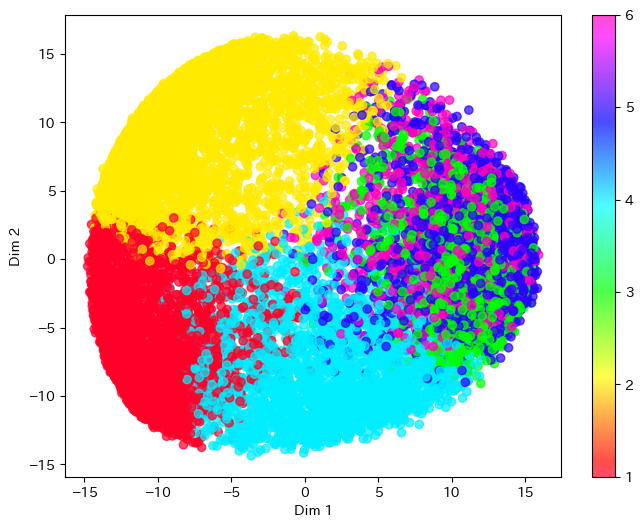

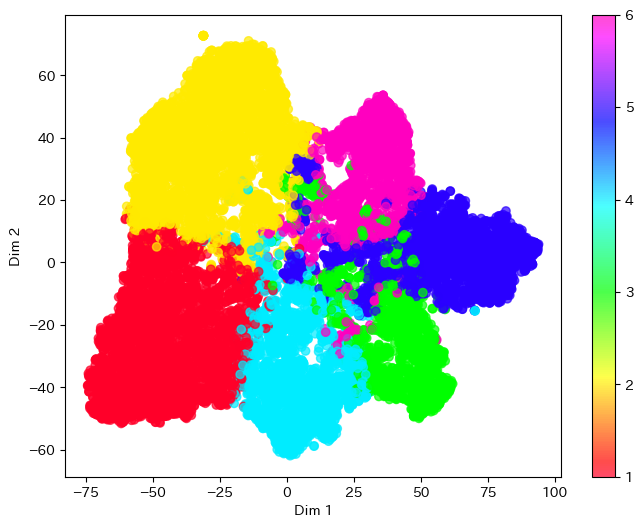

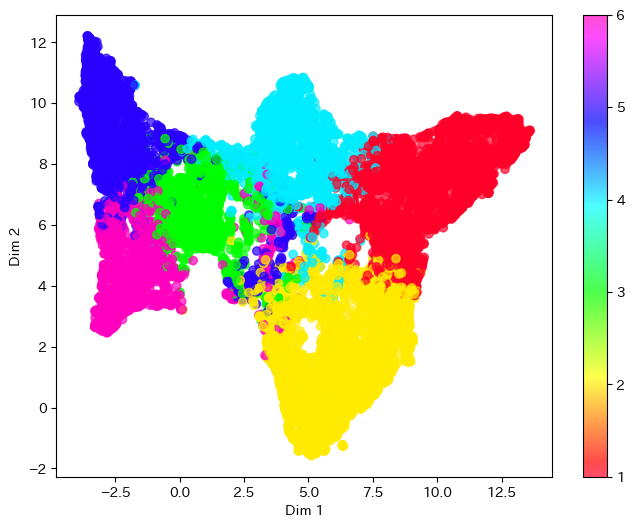

In [74]:
df_wrime_features_tsne, df_wrime_features_umap = appy_dimensionality_reduction(df_embeddings, clusters)

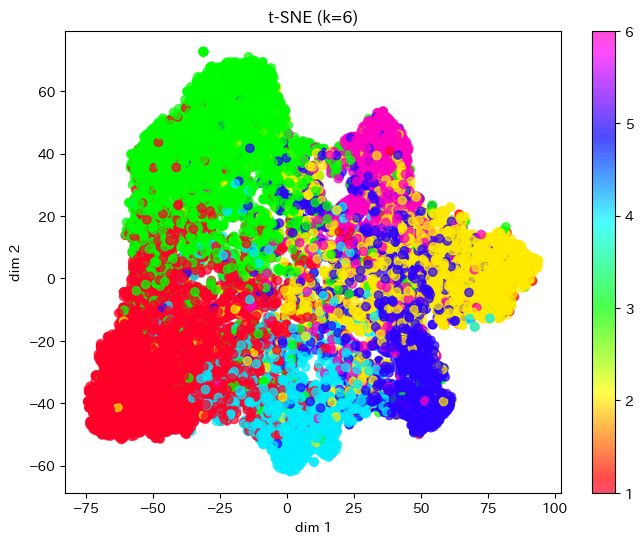

In [75]:
# t-SNE plot of the pretrained BERT-based embeddings with intensity-based cluster labels. # 吉永君正しいですよね？
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_tsne[:, 0], df_wrime_features_tsne[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

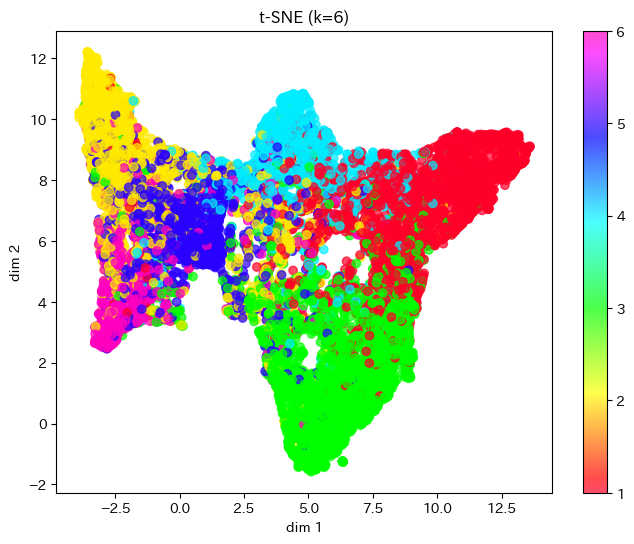

In [76]:
plt.figure(figsize=(8, 6))
plt.scatter(df_wrime_features_umap[:, 0], df_wrime_features_umap[:, 1], c=emotion_clusters, cmap=cmap_name, alpha=0.7)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.title(f't-SNE (k={len(set(emotion_clusters))})')
plt.colorbar()
plt.show()

# Finding the optimal cluster size

In [77]:
k_max=41

In [78]:
'''
from sklearn.cluster import KMeans

# Survey of optimal number of clusters by Elbow Method
SSE = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    SSE.append(kmeans_model.inertia_)

# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), SSE, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('SSE')
plt.title('Survey of optimal number of clusters by Elbow Method')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\n\n# Survey of optimal number of clusters by Elbow Method\nSSE = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    SSE.append(kmeans_model.inertia_)\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), SSE, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('SSE')\nplt.title('Survey of optimal number of clusters by Elbow Method')\nplt.grid(True)\nplt.show()\n"

In [79]:
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Survey of optimal number of clusters by Silhouette Coefficient
silhouette_coefficients = []
for i in range(2, k_max):
    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)
    silhouette_coefficient = silhouette_score(df_embeddings, kmeans_model.labels_) # シルエット係数の平均値
    silhouette_coefficients.append(silhouette_coefficient)


# 可視化
plt.figure(figsize=(8, 6))
plt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)
plt.xlabel('k')
plt.xticks(np.arange(2, k_max, 1), fontsize=8)
plt.ylabel('Silhouette Coefficient')
plt.title('Survey of optimal number of clusters by Silhouette Coefficient')
plt.grid(True)
plt.show()
'''

"\nfrom sklearn.cluster import KMeans\nfrom sklearn.metrics import silhouette_score\n\n# Survey of optimal number of clusters by Silhouette Coefficient\nsilhouette_coefficients = []\nfor i in range(2, k_max):\n    kmeans_model = KMeans(n_clusters=i, random_state=0).fit(df_embeddings)\n    silhouette_coefficient = silhouette_score(df_embeddings, kmeans_model.labels_) # シルエット係数の平均値\n    silhouette_coefficients.append(silhouette_coefficient)\n\n\n# 可視化\nplt.figure(figsize=(8, 6))\nplt.plot(range(2, k_max), silhouette_coefficients, marker='o', markersize=3)\nplt.xlabel('k')\nplt.xticks(np.arange(2, k_max, 1), fontsize=8)\nplt.ylabel('Silhouette Coefficient')\nplt.title('Survey of optimal number of clusters by Silhouette Coefficient')\nplt.grid(True)\nplt.show()\n"

### Plot showing silhouette scores

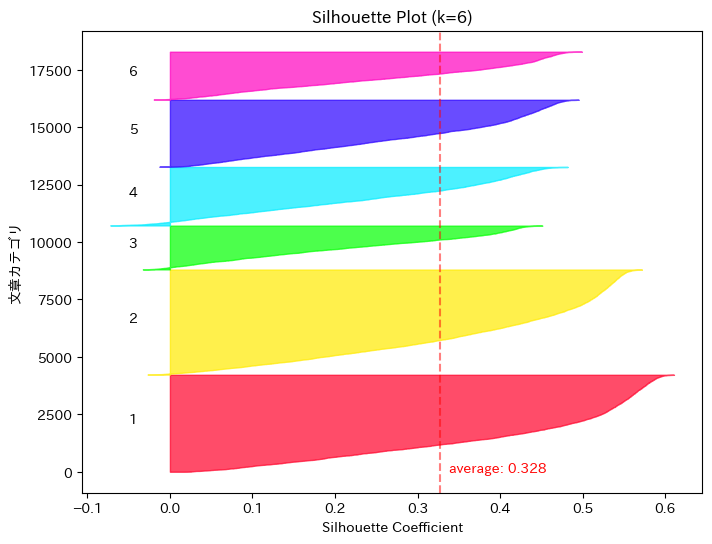

In [80]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


# データセット全体の平均シルエット係数を計算
silhouette_avg = silhouette_score(df_embeddings, clusters)

# 各サンプルのシルエット係数を計算
silhouette_values = silhouette_samples(df_embeddings, clusters)

# 可視化
plt.figure(figsize=(8, 6))
y_lower = 0
for i, cluster in enumerate(cluster_IDs):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i+1))
    y_lower = y_upper + 10

# 平均シルエット係数を直線で表示
plt.axvline(x=silhouette_avg, color="red", linestyle="--", alpha=0.5)
plt.text(silhouette_avg + 0.01, -20, f"average: {silhouette_avg:.3f}", color="red")

plt.xlabel('Silhouette Coefficient')
plt.ylabel('文章カテゴリ')
plt.title(f'Silhouette Plot (k={k})')
plt.show()

In [81]:
# The tweet with the highest silhouette coefficient in each intensity-based cluster
for i, cluster in enumerate(cluster_IDs):
    cluster_silhouette_values = silhouette_values[clusters == cluster]
    cluster_silhouette_values.sort()
    index = np.where(silhouette_values == cluster_silhouette_values[-1])[0][0]
    print(f'Intensity-based cluster ID: {clusters[index]}')
    print(f'The highest scored tweet: {df_wrime_target.iloc[index, 0]}')
    print(f'Silhouette score: {cluster_silhouette_values[-1]:.3f}')
    print('---')

Intensity-based cluster ID: 1
The highest scored tweet: 化野は行ってよかったー！雰囲気あるー！ひやっとしたよ。
Silhouette score: 0.611
---
Intensity-based cluster ID: 2
The highest scored tweet: 美味しそうなお店ないかと\n雑誌とか読んでたら色々あるから、ぶらぶらしながら行ってみよーっとw
Silhouette score: 0.572
---
Intensity-based cluster ID: 3
The highest scored tweet: はぁ、暑い！\n蜂さんいっぱい\n蜂の巣にスプレーかけただけではダメなのか？\n落とすの怖いんだけど......
Silhouette score: 0.451
---
Intensity-based cluster ID: 4
The highest scored tweet: ダウ、バク上がりしてるやん！
Silhouette score: 0.482
---
Intensity-based cluster ID: 5
The highest scored tweet: 昨日の夜はなんだか自分が無能な人間に思えて落ち込んでしまったなぁ。すぐ色々忘れるしおっちょこちょいだし、どうしようもないお荷物なのかなと思ったら悲しくなっちゃったよ。そんなことはずなんだけどなー
Silhouette score: 0.495
---
Intensity-based cluster ID: 6
The highest scored tweet: シュレッターもな、音うるさいから時間考えてやってるんやで\n今、うるさくしたらあかんやろってタイミングばっかりに溜め込んだシュレッターいきのプリントをシュレッターするんはおかしいと思うで\n周り見て動けよ\n個人プレイは必要やけどな、そういうプレイはワガママやと思うで
Silhouette score: 0.499
---


In [82]:
# 特定の文章カテゴリのシルエット係数が高い上位5件を表示
target_cluster = 5
cluster_silhouette_values = silhouette_values[clusters == target_cluster]
cluster_silhouette_values.sort()
for i in range(5):
    index = np.where(silhouette_values == cluster_silhouette_values[-i - 1])[0][0]
    # print(f'文章カテゴリ: {clusters[index]}')
    # print(f'シルエット係数が高い文章: {df_wrime_target.iloc[index, 0]}')
    # print(f'シルエット係数: {cluster_silhouette_values[-i - 1]:.3f}')
    # print('---')

    print(f'Intensity-based cluster ID: {clusters[index]}')
    print(f'The highest scored tweet: {df_wrime_target.iloc[index, 0]}')
    print(f'Silhouette score: {cluster_silhouette_values[-1]:.3f}')
    print('---')



Intensity-based cluster ID: 5
The highest scored tweet: 昨日の夜はなんだか自分が無能な人間に思えて落ち込んでしまったなぁ。すぐ色々忘れるしおっちょこちょいだし、どうしようもないお荷物なのかなと思ったら悲しくなっちゃったよ。そんなことはずなんだけどなー
Silhouette score: 0.495
---
Intensity-based cluster ID: 5
The highest scored tweet: 10日の休み勝ち取ったのに、美容室の予約は勝ち取れませんでした。\nそして、終業間際にデータ入力ミスが発覚。\n平謝りもんですわな。\nこの落ち込んだ気持ちのまま連休に突入です。\n辛い(´･_･`)
Silhouette score: 0.495
---
Intensity-based cluster ID: 5
The highest scored tweet: 考えないように考えないようにして、無理して笑ってみても、別のことを考えてもどうにも頭から離れないし、涙が出そうに辛くて、失恋を味わっている。(お気に入りのバッグが壊れた)
Silhouette score: 0.495
---
Intensity-based cluster ID: 5
The highest scored tweet: お風呂入るタイミング見失ってぎりぎりにかけてみたが賭けに負けた‥_(:3」∠)_
Silhouette score: 0.495
---
Intensity-based cluster ID: 5
The highest scored tweet: 娘、休校になったら3月ずっとひとりじゃんと思ったらめちゃくちゃ泣いちゃったし、よかったら明日ご飯食べに来てもいいのよ…と思ったら体調崩してるらしくて二重で泣いた つらい
Silhouette score: 0.495
---


### From the embeddings of tweets generated by the pretrained BERT model, infer the intensity-based cluster IDs

In [83]:
# df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clustersを結合
df_embeddings_clusters = pd.concat([df_wrime_target['Train/Dev/Test'], df_embeddings, df_intensity_clusters], ignore_index=True, axis=1)
# df_embeddings_clustersの最後の列を1引く
df_embeddings_clusters.iloc[:, -1] = df_embeddings_clusters.iloc[:, -1] - 1

df_embeddings_clusters

,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,768,769
0,train,0.774019,0.633608,-0.996681,-0.691298,-0.880096,0.984395,-0.682478,-0.075482,0.419733,...,0.377917,-0.648178,0.293988,-0.575825,-0.190243,0.848734,0.359555,1.151710,0.286147,1
1,train,0.321650,0.090575,-0.631328,-0.221017,-0.740900,1.052229,-0.361626,0.148463,0.318677,...,-0.046537,-0.568754,-0.323121,-0.255332,-0.377881,0.733498,1.291879,0.208253,-0.102930,3
2,train,0.709733,-0.194058,-1.185219,0.022576,-0.853496,0.751737,0.591366,0.351093,0.982763,...,0.012908,-0.771746,-0.187439,-0.353776,0.467980,0.038913,0.516061,0.585752,-0.749518,0
3,train,0.509768,-0.105575,-1.387828,-0.537668,-1.265315,0.817354,-0.232853,0.635667,0.158978,...,0.748806,0.877793,-0.364056,-0.299622,-0.347429,0.038030,-0.233847,0.635400,-0.227153,2
4,train,0.153026,-0.407733,-1.491600,-0.177921,-1.252778,0.557431,0.519655,0.505629,0.910844,...,0.428306,-0.190305,-0.538459,-0.039486,0.575037,0.151907,-0.153555,0.779115,-0.979037,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18232,train,-0.243897,-0.652300,-1.719894,-0.248367,-1.027574,0.467394,0.464480,0.930091,0.622621,...,0.624098,0.117266,-0.727555,0.226415,0.278733,-0.048116,-0.366162,0.495377,-0.840267,0
18233,train,-0.555585,-0.808958,-1.818868,-0.311284,-1.244205,0.245765,0.200647,0.724049,0.512956,...,0.389932,0.236154,-0.675267,0.006236,0.318394,0.016895,-0.132473,0.641663,-0.862925,2
18234,train,-0.226191,-0.772776,-1.285964,0.414030,-1.224666,0.957371,1.083040,0.637884,1.320612,...,0.606719,-0.396130,-0.517547,0.117426,0.218221,0.353194,0.664605,-0.377140,-0.927665,0
18235,train,-0.834903,-0.865983,-1.326560,-0.563771,-1.136019,0.338242,-0.083493,0.888807,0.208783,...,0.399737,0.484706,-0.590472,-0.249661,0.166233,-0.237287,-0.520062,0.942935,-0.468791,2


In [84]:
# divide into train and test
df_groups = df_embeddings_clusters.groupby(0)
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [85]:
import xgboost as xgb

# Make input data to xgboost
train_data = df_train.drop([0, 769], axis=1).values
train_labels = df_train[769].values

test_data = df_test.drop([0, 769], axis=1).values
test_labels = df_test[769].values

train_data = xgb.DMatrix(train_data, label=train_labels)
test_data = xgb.DMatrix(test_data, label=test_labels)

[0]	train-mlogloss:1.16425	test-mlogloss:1.18177
[1]	train-mlogloss:0.96119	test-mlogloss:0.99808
[2]	train-mlogloss:0.84955	test-mlogloss:0.89911
[3]	train-mlogloss:0.78286	test-mlogloss:0.84276
[4]	train-mlogloss:0.74071	test-mlogloss:0.80749
[5]	train-mlogloss:0.71338	test-mlogloss:0.78674
[6]	train-mlogloss:0.69535	test-mlogloss:0.77512
[7]	train-mlogloss:0.68207	test-mlogloss:0.76889
[8]	train-mlogloss:0.67194	test-mlogloss:0.76326
[9]	train-mlogloss:0.66420	test-mlogloss:0.76029
[10]	train-mlogloss:0.65835	test-mlogloss:0.75656
[11]	train-mlogloss:0.65377	test-mlogloss:0.75644
[12]	train-mlogloss:0.65002	test-mlogloss:0.75529
[13]	train-mlogloss:0.64697	test-mlogloss:0.75292
[14]	train-mlogloss:0.64436	test-mlogloss:0.75188
[15]	train-mlogloss:0.64194	test-mlogloss:0.74895
[16]	train-mlogloss:0.63978	test-mlogloss:0.74964
[17]	train-mlogloss:0.63775	test-mlogloss:0.75061
[18]	train-mlogloss:0.63584	test-mlogloss:0.74735
[19]	train-mlogloss:0.63394	test-mlogloss:0.74748
[20]	train

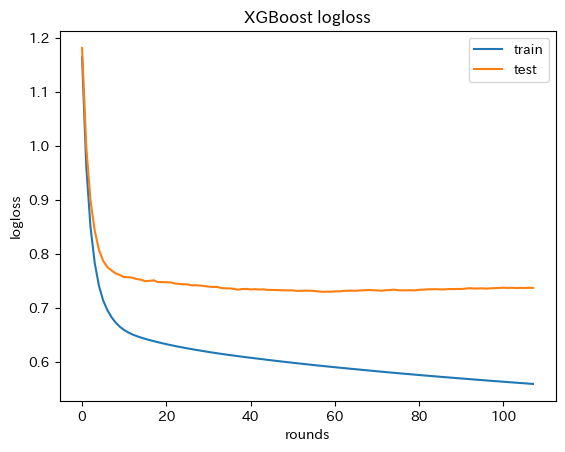

In [86]:
# Model
params = {
    'objective': 'multi:softmax',
    'num_class': len(set(emotion_clusters)),
    'eval_metric': 'mlogloss',
    'verbosity': 0,
    'seed': 0,
    'max_depth': 1,
    'eta': 0.5,
}

history = dict()

# learning
model = xgb.train(params, train_data, evals=[(train_data, 'train'), (test_data, 'test')], evals_result=history, num_boost_round=1000, early_stopping_rounds=50)

# prediciton
preds_labels = model.predict(test_data)

# Visualization
plt.plot(history['train']['mlogloss'], label='train')
plt.plot(history['test']['mlogloss'], label='test')
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.legend()
plt.show()

In [87]:
test_labels += 1
preds_labels += 1

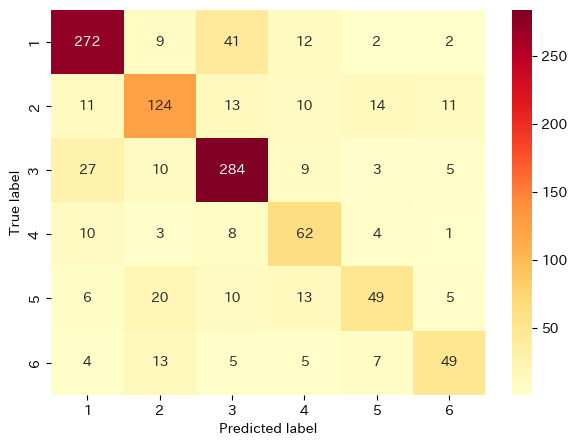

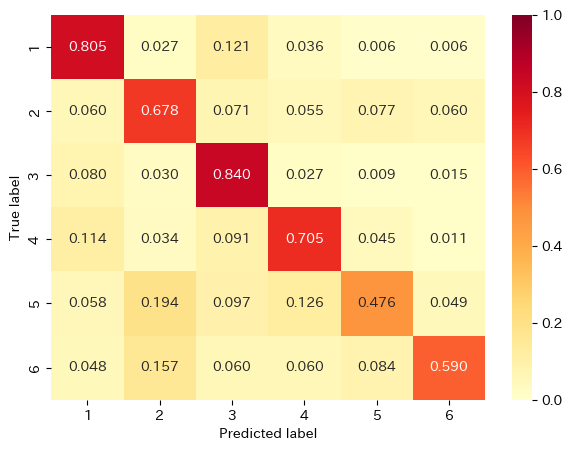

              precision    recall  f1-score   support

           1      0.824     0.805     0.814       338
           2      0.693     0.678     0.685       183
           3      0.787     0.840     0.813       338
           4      0.559     0.705     0.623        88
           5      0.620     0.476     0.538       103
           6      0.671     0.590     0.628        83

    accuracy                          0.741      1133
   macro avg      0.692     0.682     0.684      1133
weighted avg      0.741     0.741     0.739      1133



In [88]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns

# 混同行列の作成
cm = confusion_matrix(test_labels, preds_labels, labels=list(set(emotion_clusters)))

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.show()

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ヒートマップの描画
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='YlOrRd', fmt='.3f', vmin=0, vmax=1)
plt.xlabel('Predicted label')
plt.xticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.yticks(np.arange(len(set(emotion_clusters))) + 0.5, range(1, len(set(emotion_clusters)) + 1))
plt.ylabel('True label')
plt.show()

# 各クラスの適合率、再現率、F1スコアを算出
print(classification_report(test_labels, preds_labels, digits=3))

k = 6  
'cl-tohoku/bert-base-japanese-whole-word-masking' は accuracy 60%  
'cl-tohoku/bert-base-japanese-v2' は accuracy 58.6%

In [89]:
# Indices of false predictions
false_preds = np.where(test_labels != preds_labels)[0]

# Show the first 5 false predictions
for i in false_preds[10:15]:
    print(df_wrime_target.iloc[i]['Sentence'])
    print('True label:', test_labels[i])
    print('Predicted label:', preds_labels[i])
    print('---')

久しぶりにヤツが来た。ちきしょう、油断してた…コルセット生活、再開!!(T_T)
True label: 5
Predicted label: 6.0
---
はんばーぐたべたい。
True label: 5
Predicted label: 4.0
---
焼き肉いきたい。
True label: 2
Predicted label: 5.0
---
実家の母は、普段話し相手がいないのか、たまに帰るとむちゃくちゃ喋ってくる。今回、風邪気味で無口だったので、静かな正月となった。二泊三日の最終日、私を送り出す駅のホームで急に喋りだした。え、今？ どうやら風邪は治ったようです。
True label: 5
Predicted label: 2.0
---
ぐさりと刺さっても、笑ってスルーするー。でもやっぱり気にして髪形変えたりする。
True label: 4
Predicted label: 5.0
---


---